In [2]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [3]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [4]:
import pandas as pd
import numpy as np
import graphviz as gr
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(30)

In [5]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

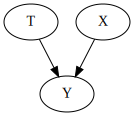

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g

1a: Do not control for any covariates

In [7]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:03<00:00, 153.89it/s]


In [8]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [9]:
tauhat,se_tauhat

(2.2395431070751357, 0.2057030945818077)

In [10]:
const = np.ones([N,1])

In [11]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(2.2395431070751353, 0.2057030945818077)

In [12]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:10<00:00, 187.42it/s]


In [13]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0021963111021054164, RMSE=0.20529032915794948, size=0.053
N=1000: bias=0.00038537583037882763, RMSE=0.0634219903364923, size=0.0455


In [14]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [15]:
tauhat,se_tauhat

(1.919725964310933, 0.06275166372465822)

In [16]:
const = np.ones([N,1])

In [17]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(1.919725964310934, 0.06275166372465826)

In [18]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:09<00:00, 200.27it/s]


In [19]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.005120100510548955, RMSE=0.1976654218566345, size=0.053
N=1000: bias=-0.00011355017474051476, RMSE=0.0628813749536623, size=0.053


1b: Control for all the covariates

In [20]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 900/900 [00:04<00:00, 183.34it/s]


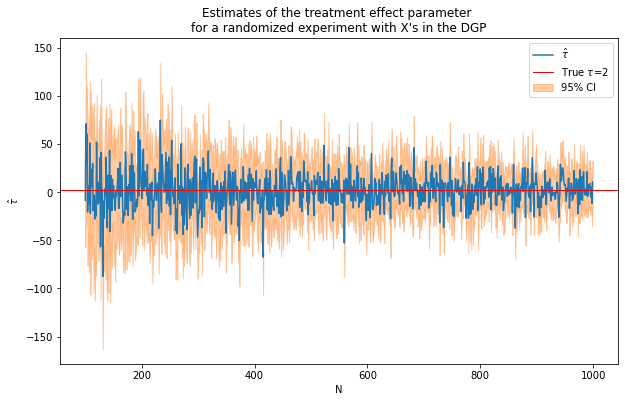

In [21]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [22]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(100,1000) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 900/900 [00:05<00:00, 165.98it/s]


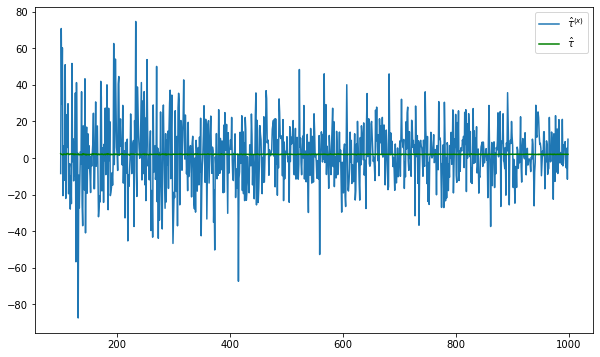

In [23]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

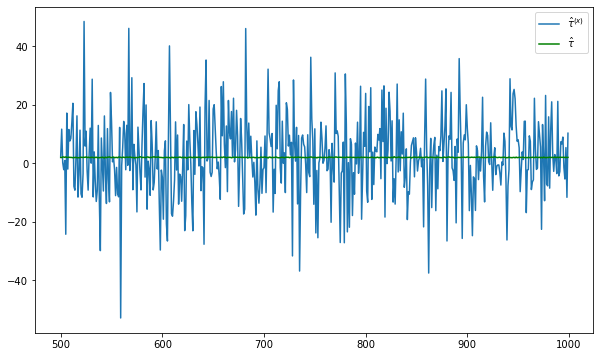

In [24]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

In [25]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000) # loop over N values
(nvalues_x2,tauhats_x2,sehats_x2,lb_x2,ub_x2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 900/900 [00:04<00:00, 186.37it/s]


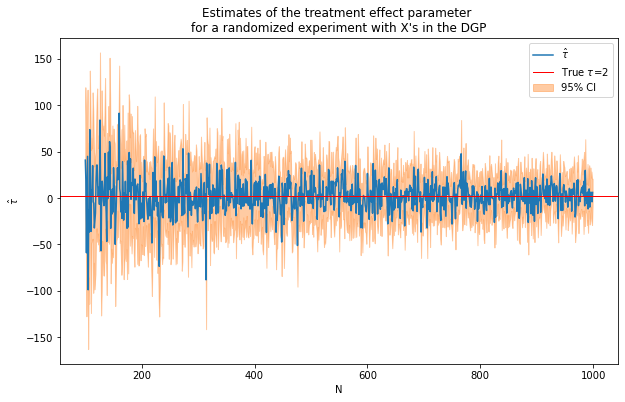

In [26]:
fn_plot_with_ci(nvalues_x2,tauhats_x2,tau,lb_x2,ub_x2,caption)

Example:

For ice cream sales dataset, we can use the effects of covariates on the outcome (sales) and treatment (price) to estimate treatment effectiveness.Estimate the same parameters using the same model containing the treatment and covariates.If the model is flexible means don't have to make any parametric assumption about the relationship between the covariates and the outcome. Predict prices from the covariates temp, weekday and cost.

2a: fail to control for the confounder

In [27]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(2,10,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [28]:
mcSim_100 = MC_Simulator(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)

mcSim_1000 = MC_Simulator(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['Bias','RMSE','Treatment effect']]
res

,N=100,N=1000
Bias,-1.127440,-1.117697
RMSE,10.683125,10.775615
Treatment effect,-1.127440,-1.117697


2b: do control for the confounder

In [29]:
class MC_Simulator_1():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(2,10,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(a + b*T + c*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [30]:
mcSim_100 = MC_Simulator_1(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)

mcSim_1000 = MC_Simulator_1(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','Treatment effect']]
res

C:\Users\78411\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,-1.150233,-1.112901
RMSE,4.757488,4.839945
Treatment effect,0.868322,0.899883


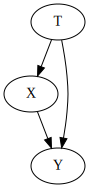

In [31]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g

Example:

Let’s consider a drug test scenario with 2 hospitals. Both of them are conducting randomised trials on a new drug to treat a certain illness. The outcome of interest is days hospitalised. If the treatment is effective, it will lower the amount of days the patient stays in the hospital. For one of the hospitals, the policy regarding the random treatment is to give it to 90% of its patients while 10% get a placebo. The other hospital has a different policy: it gives the drug to a random 10% of its patients and 90% get a placebo.

3a:control for the variable in between the path from cause to effect

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import graphviz as gr

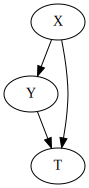

In [33]:
g = gr.Digraph()
g.edge("X", "Y")
g.edge("X", "T")
g.edge("Y", "T")
g

In [34]:
np.random.seed(20)
n = 1000
T = np.random.binomial(1, 0.5, n)
Y = np.random.normal(8 + 8*T, 5).astype(int)
X = np.random.normal(22+np.mean(T)*np.mean(Y),10,n)

data1 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data1.to_csv("data1.csv", index=False)

In [35]:
class MC_Simulator_2():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(8 + 8*T, 5).astype(int)
        X = np.random.normal(22+np.mean(T)*np.mean(Y),10,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [36]:
mcSim_100 = MC_Simulator_2(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)

mcSim_1000 = MC_Simulator_2(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','Treatment effect']]
res

C:\Users\78411\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,7.948712,7.936847
RMSE,4.869943,4.946662
Treatment effect,7.947594,7.936860


3b: do not control for the variable in between the path from cause to effect

In [37]:
class MC_Simulator_3():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(8 + 8*T, 5).astype(int)
        X = np.random.normal(22+np.mean(T)*np.mean(Y),10,n)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [38]:
mcSim_100 = MC_Simulator_3(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)

mcSim_1000 = MC_Simulator_3(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,7.952333,7.940268
RMSE,4.895825,4.949258
treatment effect,7.952333,7.940268


Example:

For relationship between wages and education,  compare wages of individuals with and without a college degree. Mostly result suggests that having a college degree more than doubles wages.
If not held constant, others factors can produce a spurious correlation between the two variables of interest, which may be mistakenly interpreted as a causal link.